# TODO：概要

# ライブラリのインポート

In [12]:
import os
import time
import json
import datetime
import zoneinfo

import requests

from dotenv import load_dotenv, find_dotenv

from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import (
    MessageTextContent,
    ListSortOrder,
    McpTool,
    MCPToolDefinition,
    RequiredMcpToolCall,
    SubmitToolApprovalAction,
    ToolApproval,
    CodeInterpreterTool,
    FunctionTool,
    ToolSet,
)
from IPython.display import Image, display

# 環境変数の取得

In [13]:
load_dotenv(override=True)

PROJECT_ENDPOINT=os.getenv("PROJECT_ENDPOINT")
AZURE_DEPLOYMENT_NAME=os.getenv("AZURE_DEPLOYMENT_NAME")

# クライアントの初期化

In [14]:
# AI Project Client を初期化
project_client = AIProjectClient(
    endpoint=PROJECT_ENDPOINT,
    credential=DefaultAzureCredential()
)

# AgentClient の作成
agents_client = project_client.agents

# ユーティリティ関数

In [15]:
def agent_run_outputs(thread_id, agents_client, target_dir="./output_images"):
    """
    指定したスレッドIDのRun実行結果（テキスト・画像）をNotebook上に表示＆画像は保存。
    """
    messages = agents_client.messages.list(thread_id=thread_id, order=ListSortOrder.ASCENDING)
    os.makedirs(target_dir, exist_ok=True)

    for message in messages:
        # テキスト出力
        if message.text_messages:
            for txt in message.text_messages:
                print(f"{message.role.upper()}: {txt.text.value}")
        
        # 画像出力
        if hasattr(message, "image_contents"):
            for image_content in message.image_contents:
                file_id = image_content.image_file.file_id
                file_name = f"{file_id}_image_file.png"

                agents_client.files.save(
                    file_id=file_id,
                    file_name=file_name,
                    target_dir=target_dir
                )
                print(f"Saved image: {file_name}")
                display(Image(filename=f"{target_dir}/{file_name}"))

# ツールの定義

In [16]:
# Code Interpreter ツールの定義
codeinterpreter = CodeInterpreterTool()

# ツールセットの定義
toolset = ToolSet()
toolset.add(codeinterpreter)

# エージェントの作成

In [17]:
code_interpreter_agent = agents_client.create_agent(
    model=AZURE_DEPLOYMENT_NAME,
    name="code_interpreter_agent",
    instructions=(
        "あなたは計算や図表の出力に特化したアシスタントです。"
        "利用可能なツールを確認し、必要に応じて使用してください。"    
        "なお、グラフを描画する際は日本語が文字化けするため、ラベルやタイトルは英語で出力してください。"    
    ),
    description=(
        "Code Interpreter を利用して、計算や図表の出力に特化した分析アシスタントです。"
    ),
    tools=toolset.definitions,
)
print(f"Created Agent. AGENT_ID: {code_interpreter_agent.id}")


Created Agent. AGENT_ID: asst_NChQyAQy7cnZJ1OyV6fOtXoq


# スレッドの作成

In [18]:
# Thread の作成
thread = agents_client.threads.create()
print(f"Created Thread. THREAD_ID: {thread.id}")

Created Thread. THREAD_ID: thread_FV1ZeAhEq9DIgh0MgSE0baSe


# ユーザーメッセージの追加

In [19]:
# メッセージの追加
user_message_01= (
    "初期投資額が100万円、年利回りが3.5%、毎年10万円ずつ追加投資を"
    "20年間継続したときの最終的な資産額を計算し、円単位で四捨五入して答えてください。"
)

message = agents_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=user_message_01,
)

print(f"Added Message. MESSAGE_ID: {message.id}")

Added Message. MESSAGE_ID: msg_UmkrSTUX1hwl8HjtuhsWd2vL


# Run の実行

## 1 ターン目

In [20]:
run = agents_client.runs.create_and_process(
    thread_id=thread.id,
    agent_id=code_interpreter_agent.id
)

if run.status == "failed":
    print(f"Run failed: {run.last_error}")
else:
    agent_run_outputs(thread.id, agents_client)

USER: 初期投資額が100万円、年利回りが3.5%、毎年10万円ずつ追加投資を20年間継続したときの最終的な資産額を計算し、円単位で四捨五入して答えてください。
ASSISTANT: 条件に基づき、以下の計算を行います。

- 初期投資額: 1,000,000円  
- 年利回り: 3.5%  
- 追加投資: 毎年100,000円  
- 投資期間: 20年

毎年の積立投資（追加投資）分には複利が効くため「年一回複利運用」として計算します。

計算式（未来価値FV）:
- 初期投資元本の複利分: \( FV_1 = P \times (1 + r)^n \)
- 積立部分の未来価値: \( FV_2 = PMT \times \{[(1 + r)^n - 1 ] / r\} \)

ここで  
P = 初期投資額  
PMT = 年間追加投資額  
r = 年利（小数）  
n = 年数

この計算を実行します。
ASSISTANT: 最終的な資産額は、4,817,757円（四捨五入後）です。


## 2 ターン目

USER: 初期投資額が100万円、年利回りが3.5%、毎年10万円ずつ追加投資を20年間継続したときの最終的な資産額を計算し、円単位で四捨五入して答えてください。
ASSISTANT: 条件に基づき、以下の計算を行います。

- 初期投資額: 1,000,000円  
- 年利回り: 3.5%  
- 追加投資: 毎年100,000円  
- 投資期間: 20年

毎年の積立投資（追加投資）分には複利が効くため「年一回複利運用」として計算します。

計算式（未来価値FV）:
- 初期投資元本の複利分: \( FV_1 = P \times (1 + r)^n \)
- 積立部分の未来価値: \( FV_2 = PMT \times \{[(1 + r)^n - 1 ] / r\} \)

ここで  
P = 初期投資額  
PMT = 年間追加投資額  
r = 年利（小数）  
n = 年数

この計算を実行します。
ASSISTANT: 最終的な資産額は、4,817,757円（四捨五入後）です。
USER: グラフで出力して下さい。
ASSISTANT: 上記のグラフは、20年間にわたって資産がどのように増加していくかを示しています。縦軸が資産額（円）、横軸が経過年数です。初期投資と積立分がともに年利3.5%で運用された場合の資産成長曲線になります。
Saved image: assistant-6mCK1XmPLQjUtZe5DmSs3y_image_file.png


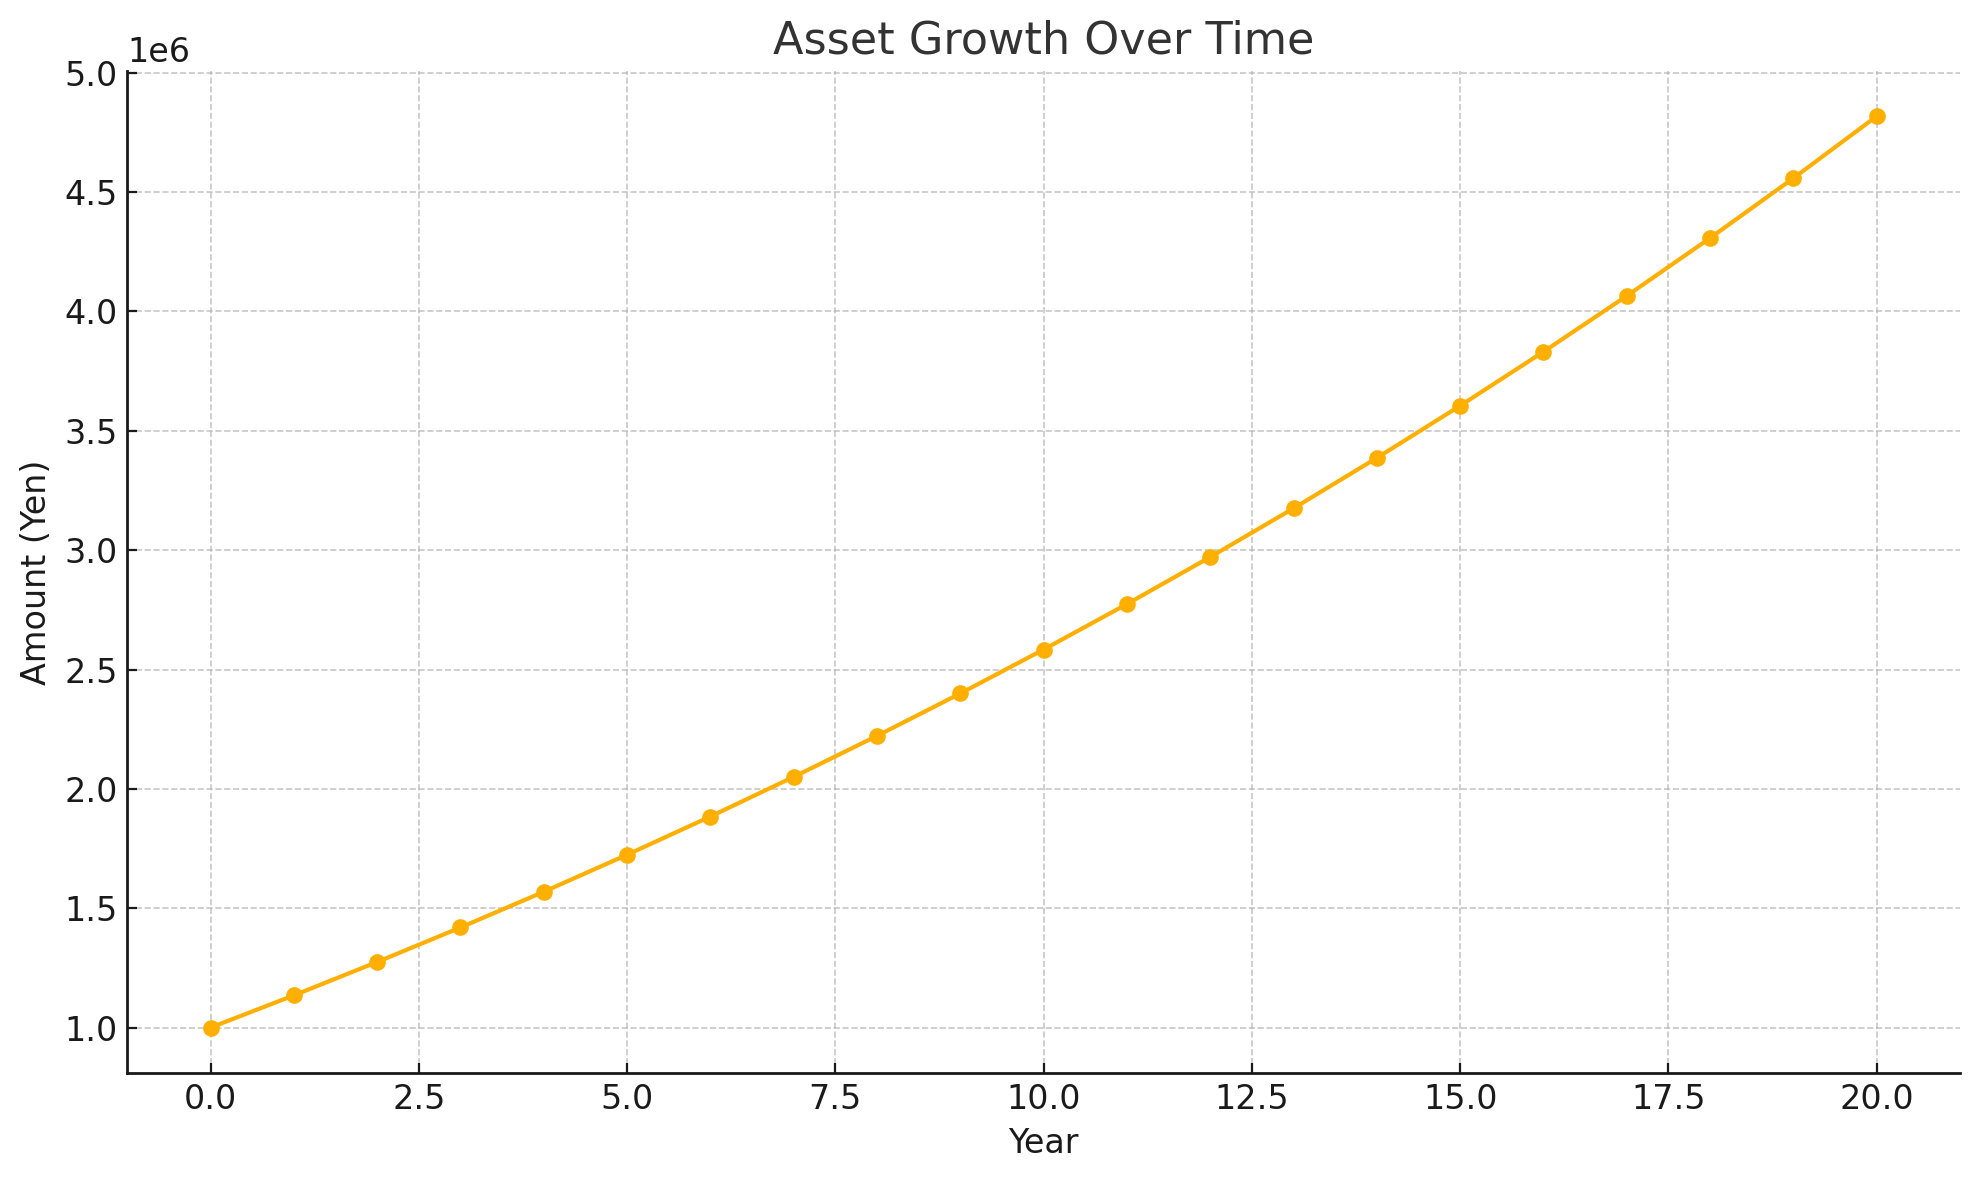

In [21]:
# メッセージの追加
user_message_02 = "グラフで出力して下さい。"

message = agents_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=user_message_02,
)


# Run の実行
run = agents_client.runs.create_and_process(
    thread_id=thread.id,
    agent_id=code_interpreter_agent.id
)


# Run の結果を確認
if run.status == "failed":
    print(f"Run failed: {run.last_error}")
else:
    agent_run_outputs(thread.id, agents_client)

※ ここで、Azure AI Foundry 上の Web UI からエージェントのトレースを確認してみよう。

# Agent ID を .env ファイルに保存
※ 今回作成したエージェントを、後続の Connected Agents のハンズオン演習で使用するため永続化します。

In [22]:
# 変数の定義
agent_env_key = "FOUNDRY_CODE_INTERPRETER_AGENT_ID"
agent_env_value = code_interpreter_agent.id

# .envファイルのパスを自動探索
env_path = find_dotenv()  # 見つからなければ''を返す
if not env_path:
    raise FileNotFoundError(".envファイルが見つかりませんでした。")

# AGENT_ID を .env ファイルに追記
with open(env_path, "a", encoding="utf-8") as f:
    f.write(f'\n{agent_env_key}="{agent_env_value}"')

print(f'.envファイルに {agent_env_key}=\"{agent_env_value}\" を追記しました。')


.envファイルに FOUNDRY_CODE_INTERPRETER_AGENT_ID="asst_NChQyAQy7cnZJ1OyV6fOtXoq" を追記しました。
